In [1]:
class PID:
    """
    Control input: wheel rpm/angular velocity
    State: [pitch]
    """
    def __init__(self, Kp=0.0, Ki=0.0, Kd=0.0):
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd

        self.previous_error = 0.0
        self.integral = 0.0

    def update(self, error, dt) -> float:
        proportional = error
        self.integral = (error + self.previous_error) / 2 * dt
        derivative = (error - self.previous_error) / dt
        return self.Kp * proportional + self.Ki * self.integral + self.Kd * derivative

In [2]:
# TODO:
# Figure out car's ground-truth pitch angle at a timestamp & animate 
# PID pitch control with input angular velocity; generate pitch plot for the entire duration


In [3]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import animation
import math as m
from math import cos, sin, pi


class RaceCar():
    def __init__(self, params):
        self.params = params
        self.l = params['car_l']
        self.h = params['car_h']
        self.mass_car = params['car_mass']
        self.mass_wheel = params['wheel_mass']
        self.mass_axis = params['axis_mass']
        self.g = params['gravity']
        
        self.wheel_radius = params['wheel_radius']
        self.axis_radius = params['axis_radius']
        self.d = params['distance_cm']
        # Fixed for now; need a separate control problem if take take-off velocity as an input
        self.take_off_v = params['take_off_velocity']
        # duration for the entire motion
        self.duration = 3.0
        # Distance between two slopes
        self.distance = params['distance']
        
        self.vel_min = 1.0
        self.vel_max = 5.0
        
        
        self.pid = PID(0.5, 1e-5, 1e-5) #PID pitch control
        self.dt = 0.1
        
    def calculate_angular_vel(self, v):
        I_w = 2* (self.mass_wheel * self.wheel_radius ** 2 + self.mass_axis * self.axis_radius**2)
        omega_w = v / self.wheel_radius
        L_w = omega_w * I_w
        I_cm = self.mass_car * (self.l**2+self.h**2) / 12
        I_parallel_axis = I_cm + self.mass_car * self.d**2
        omega_car = L_w / I_parallel_axis
        return omega_car ;
    
    def get_gt_position(self, t, v, theta):
        x = ((v*t)*np.cos(theta))
        y = ((v*t)*np.sin(theta))-((0.5*self.g)*(t**2))
        return x, y
    
    def get_pitch_angle(self, t, v):
        """
        t: timestamp t
        v: velocity of wheel in the air, from '/drive' topic
        """
        angular_vel = self.calculate_angular_vel(v)
        return angular_vel * t
    
    def step(self, t, v):
        gt_pitch = self.get_pitch_angle(t, v)
        noise = np.random.normal(0,1,1)
        curr_pitch = gt_pitch + noise #This is from IMU in reality
        error = np.abs(curr_pitch - gt_pitch)
        velocity_car = self.pid.update(error, self.dt)
        angular_velocity = velocity_car / self.wheel_radius
        print(angular_velocity)
        
    
    """
    TODO:
    - gt vs predicted pitch over time 
    - speed over time 
    - parabola
    
    """
    def plot_pitch_angle(self, theta):
        fig = plt.figure()
        ax = fig.add_subplot(111)

        r1 = patches.Rectangle((0,0), self.l, self.h, color="blue", alpha=0.50)
        r2 = patches.Rectangle((0,0), self.l, self.h, color="red",  alpha=0.50)
        t2 = mpl.transforms.Affine2D().rotate_deg(theta*180) + ax.transData
        r2.set_transform(t2)
        ax.add_patch(r1)
        ax.add_patch(r2)
        plt.xlim(-20, 60)
        plt.ylim(-20, 60)
        plt.grid(True)
        plt.show()
        
    def animate_pitch(self, v):#TODO: debug
        fig = plt.figure()
        ax = fig.add_subplot(111)
        t = np.arange(0, self.duration, 0.1)  
        thetas = []
        def animate(theta):
            r1 = patches.Rectangle((0,0), self.l, self.h, color="blue", alpha=0.50)
            r2 = patches.Rectangle((0,0), self.l, self.h, color="red",  alpha=0.50)
            t2 = mpl.transforms.Affine2D().rotate_deg(theta*180) + ax.transData
            r2.set_transform(t2)
            ax.add_patch(r1)
            ax.add_patch(r2)
            return ax
            
        for dt in t:
            theta = self.get_pitch_angle(dt, v)
            thetas.append(theta)
        
        anim = animation.FuncAnimation(fig, animate, 
                               frames=thetas, 
                               interval=20,
                               blit=True)
        plt.show()

        
    def plot_state_response(self):
        angular_vel = []
        vel_data = np.arange(self.vel_min,self.vel_max,0.1)
        for vel in vel_data:
            omega_car = self.calculate_angular_vel(vel)
            angular_vel.append(omega_car)
        plt.plot(angular_vel)
        plt.title('Angular velocity vs. take-off velocity')
        plt.ylabel('Angular velocity')
        plt.xlabel('Take off vel')
        plt.show()
    

    def plot_projectile_motion(self):
        # assume constant velocity
        v = 30
        # slope angle
        theta = np.arange(m.pi/6, m.pi/3, m.pi/36)

        t = np.linspace(0, 5, num=100) # Set time as 'continous' parameter.

        for i in theta: # Calculate trajectory for every angle
            x1 = []
            y1 = []
            for k in t:
                x = ((v*k)*np.cos(i)) # get positions at every point in time
                y = ((v*k)*np.sin(i))-((0.5*self.g)*(k**2))
                x1.append(x)
                y1.append(y)
            p = [i for i, j in enumerate(y1) if j < 0] # Don't fall through the floor                          
            for i in sorted(p, reverse = True):
                del x1[i]
                del y1[i]

            plt.plot(x1, y1) # Plot for every angle
        plt.title('Parabola motion of car movement')
        plt.xlabel('x(t)')
        plt.ylabel('y(t)')
        plt.show() # And show on one graphic



In [8]:
%matplotlib notebook
params = {'car_l': 0.3303*100, #centimeters #'lf': 0.15875, 'lr': 0.17145 according to f1tenth_gym
          'car_h': 0.145*100,  #centimeters
          'car_mass': 2.4192, #kg
          'wheel_mass': 0.1802,  #kg #TODO
          'axis_mass': 0.1, #kg #TODO
          'axis_radius': 0.01115*100, #centimeters
          'wheel_radius': 0.04826*100, #centimeters
          'distance_cm': 2.0, #centimeters: distance between the center of mass 
          'gravity': 9.81, #m/s^2
          'take_off_velocity': 2.0, #m/s
          'distance': 0.5 #m
         }
car = RaceCar(params)
# pitch = car.get_pitch_angle(1.0, 5.0)
car.step(1.0, 1.0)
# car.animate_pitch(2.0)
# car.plot_pitch_angle(pitch)
# car.plot_projectile_motion()
# print(car.get_gt_position(1, 30, m.pi/6))

[0.18631302]


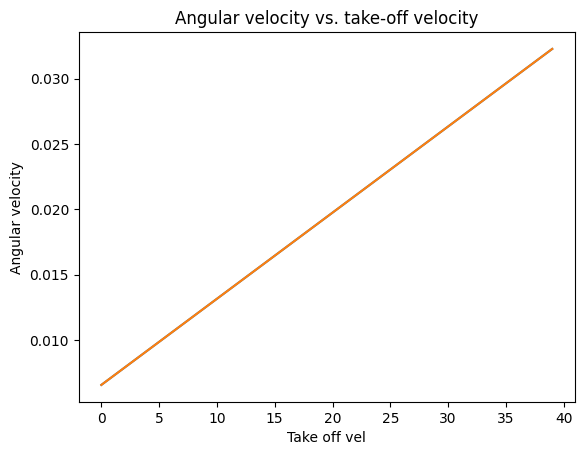

In [14]:
params = {'car_l': 0.3303*100, #centimeters #'lf': 0.15875, 'lr': 0.17145 according to f1tenth_gym
          'car_h': 0.145*100,  #centimeters
          'car_mass': 2.4192, #kg
          'wheel_mass': 0.1802,  #kg #TODO
          'axis_mass': 0.1, #kg #TODO
          'axis_radius': 0.01115*100, #centimeters
          'wheel_radius': 0.04826*100, #centimeters
          'distance_cm': 2.0, #centimeters: distance between the center of mass 
          'gravity': 9.81, #m/s^2
          'take_off_velocity': 2.0 #m/s
         }
car = RaceCar(params)
car.plot_state_response()

Traceback (most recent call last):
  File "/home/chris/.local/lib/python3.8/site-packages/matplotlib/cbook/__init__.py", line 196, in process
    func(*args, **kwargs)
  File "/home/chris/.local/lib/python3.8/site-packages/matplotlib/animation.py", line 1467, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


<IPython.core.display.Javascript object>


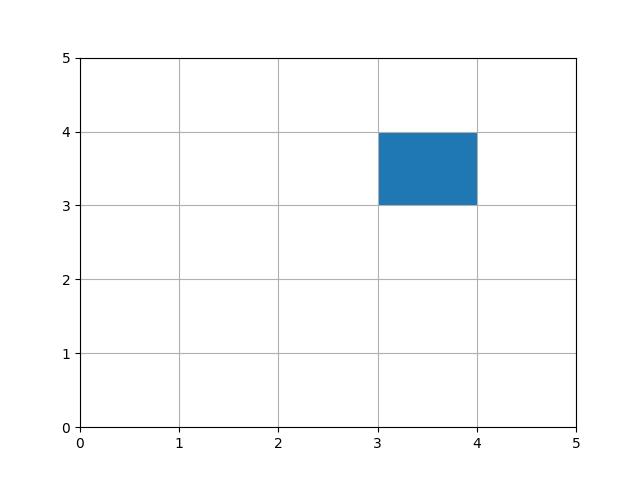

In [58]:
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.animation
from matplotlib.patches import Rectangle

moving_block = [[0,0],[1,1],[2,2],[3,3],[4,4],[5,5]]

fig, ax = plt.subplots()
#set gridlines and lines every one unit
ax.grid(which='both')
ax.axis([0, 5, 0, 5])

rectangle = Rectangle(moving_block[0], 1,1)
ax.add_patch(rectangle)

def animate(i):
    ax.clear()
    ax.axis([0, 5, 0, 5])
    ax.grid(which='both')
    ax.add_patch(Rectangle(moving_block[i], 1,1))


ani = matplotlib.animation.FuncAnimation(fig, animate,
                frames=len(moving_block), interval=300, repeat=True)

plt.show()

<IPython.core.display.Javascript object>


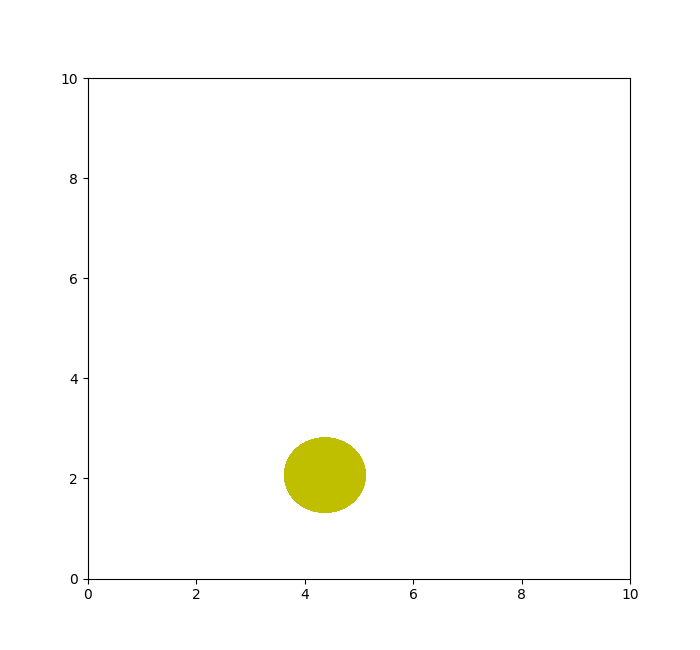

In [34]:
%matplotlib notebook
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation

fig = plt.figure()
fig.set_dpi(100)
fig.set_size_inches(7, 6.5)

ax = plt.axes(xlim=(0, 10), ylim=(0, 10))
patch = plt.Circle((5, -5), 0.75, fc='y')

def init():
    patch.center = (5, 5)
    ax.add_patch(patch)
    return patch

def animate(i):
    x, y = patch.center
    x = 5 + 3 * np.sin(np.radians(i))
    y = 5 + 3 * np.cos(np.radians(i))
    patch.center = (x, y)
    return patch

anim = animation.FuncAnimation(fig, animate, 
                               init_func=init, 
                               frames=360, 
                               interval=20,
                               blit=True)

plt.show()